In [111]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
#import matplotlib.pyplot as pyplot
import time
import numpy as np
import os
import sys

refineMesh = True

In [112]:
RES = 128
Xres = RES 
Yres = RES + 8

MAXY = float(Yres)/Xres 

dy = MAXY/Yres
dim = 2
ALPHA = 11.

RES = 128
Xres = RES 
Yres = RES

MAXY = 1. 

dy = MAXY/Yres
dim = 2
ALPHA = 11.

In [113]:
MAXY, dy

(1.0625, 0.0078125)

In [114]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("Q1/dQ0"), 
                                         elementRes=(Xres, Yres), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(1.,MAXY), periodic=[True,False] )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

In [115]:
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

In [116]:
if refineMesh:
    alpha=ALPHA
    newys = []
    newxs = []
    for index, coord in enumerate(linearMesh.data):
        y0 = coord[1]
        x0 = abs(coord[0])
        if y0 >= 1.0 + dy:
            newy = y0
        else:
            newy = (math.log(alpha*y0 + math.e) - 1)*(1/(math.log(alpha + math.e) - 1))
        newx = (math.log((alpha/2.)*x0 + math.e) - 1)*(1/(math.log((alpha/2.) + math.e) - 1))
        if coord[0] <= 0:
            newx = -1.*newx
        newys.append(newy)
        newxs.append(newx)
        
    with linearMesh.deform_mesh():
        linearMesh.data[:,1] = newys
        linearMesh.data[:,0] = newxs

In [117]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.


In [118]:
dres = 96
dummyelementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                         elementRes = (dres, dres), 
                                           minCoord = (0., 0.), 
                                           maxCoord = (1., 1.))

dummytemperatureMesh = dummyelementMesh 
dummytemperatureField = uw.fevariable.FeVariable( feMesh=dummytemperatureMesh, nodeDofCount=1 )
dummytemperatureField.load('temp_ics/temperatureField_4_10200.hdf5')

for index, coord in enumerate(elementMesh.data):
    #This bit determines whether you see a reflected image or not
    xpos, ypos = (coord[0]), coord[1]
    if ypos > 1.:
        temperatureField.data[index] = 0.
    else:
        temperatureField.data[index] = dummytemperatureField.evaluate((xpos, ypos))

            

In [119]:
#temperatureField.load('temp_ics/temperatureField_4_10200.hdf5')

In [120]:
 temperatureField.evaluate((0.5, 0.9))

array([[ 0.4929116]])

In [121]:
snum = 1000.
yp = 0.9947

linearMesh.data[:,0].max()
xps = np.linspace(linearMesh.data[:,0].min(),linearMesh.data[:,0].max(), snum)
yps = [yp for i in xps]

surfintswarm = uw.swarm.Swarm( feMesh=elementMesh )
dumout = surfintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)


yps = [ 1.- yp  for i in xps]

baseintswarm = uw.swarm.Swarm( feMesh=elementMesh )
dumout = baseintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)


tempgrad = temperatureField.gradientFn
valcheck = tempgrad[1].evaluate(surfintswarm)
valcheck.sum()*dx

-6.5592866946268096

In [122]:
dx = (linearMesh.data[:,0].max()- linearMesh.data[:,0].min())/snum

In [123]:
for yp in np.linspace(0.9999999, 0.99, 20):
    snum = 1000.
    #yp = 0.9947

    linearMesh.data[:,0].max()
    xps = np.linspace(linearMesh.data[:,0].min(),linearMesh.data[:,0].max(), snum)
    yps = [yp for i in xps]

    surfintswarm = uw.swarm.Swarm( feMesh=elementMesh )
    dumout = surfintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)


    yps = [ 1.- yp  for i in xps]

    baseintswarm = uw.swarm.Swarm( feMesh=elementMesh )
    dumout = baseintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)


    tempgrad = temperatureField.gradientFn
    valcheck = tempgrad[1].evaluate(surfintswarm)
    print valcheck.sum()*dx

-6.55928669463
-6.55928669463
-6.55928669463
-6.55928669463
-6.55928669463
-6.55928669463
-6.55928669463
-6.55928669463
-6.55928669463
-6.55928669463
-6.55928669463
-6.55928669463
-6.55928669463
-6.55928669463
-6.55928669463
-6.50325966958
-6.50325966958
-6.50325966958
-6.50325966958
-6.50325966958


In [124]:
0.01*2890

28.900000000000002

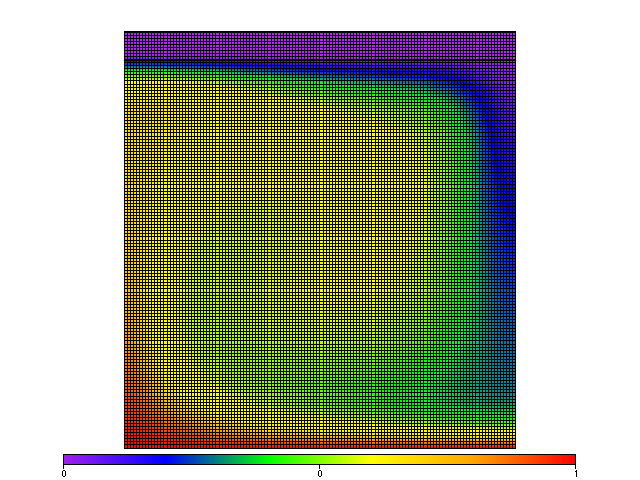

In [110]:
fig1 = plt.Figure()
#fig1.Surface(buoyancyFn[1], elementMesh)
fig1.Surface(temperatureField, elementMesh)
#fig1.Points( swarm=gSwarm, colourVariable=materialVariable , pointSize=0.5, colours='white blue red black')
fig1.Mesh(linearMesh)
#fig1.VectorArrows(velocityField, linearMesh, lengthScale=0.002)
fig1.Points( swarm=surfintswarm,  pointSize=2.0)

fig1.show()
#fig1.save_database('test_mesh_refine.gldb')


In [12]:
2*192

384

Res = 384
yp = 0.9947

-6559.4131248560989
-6559.431503660303


In [41]:
elsize = (1/96.)

In [42]:
elsize

0.010416666666666666

In [44]:
1 - elsize/2

0.9947916666666666

In [20]:
for yp in np.linspace(0.9999999, 0.99, 20):
    print yp

0.9999999
0.999473589474
0.998947278947
0.998420968421
0.997894657895
0.997368347368
0.996842036842
0.996315726316
0.995789415789
0.995263105263
0.994736794737
0.994210484211
0.993684173684
0.993157863158
0.992631552632
0.992105242105
0.991578931579
0.991052621053
0.990526310526
0.99
